# Symmetric power spectra in 2D images, with beam smoothing

## Last edited by Charles Romero 09 July 2025

That is, we can characterize the power spectra with $k_r$, where $k_r = (k_x^2 + k_y^2)^{1/2}$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ComputePS as CPS
import image_filtering as imf

Let's define some simple parameters for an image and a power spectrum.

In [3]:
nPix = 1024                  # Number of pixels on a side (square image)
pixsize = 1.0                # Assume this is in kpc
units = "kpc"                # Let's have a string that goes with this.
kc = 3e-5                    # Assume this is in [pixsize]^(-1) -- so kpc^-1 in our case.
slope = -3.667               # Power goes as k**slope
p0 = 9e-4                    # Arbitrary units at the moment
fwhm = 5.0                   # kpc
s2f = 2*np.sqrt(2*np.log(2)) # Gaussian sigma to FWHM (if needed)
pixfwhm = fwhm/pixsize       # FWHM in pixels

In [4]:
PSobj = CPS.ImagesFromPS(nPix,pixSize=pixsize,slope=slope,kc=kc,p0=p0)
ks = PSobj.get_logspaced_k()
ps = PSobj.get_parameterized_PS(ks)

In [35]:
def SpectraPlottingSetup(waveNumber,powerSpectrum,pltUnits,figNum=1,figsize=(4,3),dpi=200,twoD=True,AmpSpec=False,
                        psax=None,label=None,showLegend=False,ymin=None,ymax=None,legendFS=8,**kwargs):
    """
    Feel free to set up figures how you like. We'll make a few figures, so I'll make a function for the basic setup.
    I'll return the figure and axes objects in case more is to be done with them (foreshadowing)
    """
    if psax is None:
        dosetup = True
        psfig = plt.figure(figNum,figsize=figsize,dpi=dpi)
        psfig.clf() # If rerunning cell
        psax = psfig.add_subplot(111)
        psax.set_xscale("log")
        psax.set_yscale("log")
    else:
        dosetup = False
    if AmpSpec:
        if powerSpectrum.ndim == 2:
            WNreshaped = waveNumber.reshape(waveNumber.size,1)
            PSshape = powerSpectrum.shape
            WNreshaped = WNreshaped.repeat(PSshape[1],axis=1)
        else:
            WNreshaped = waveNumber
        tempQuantity = 2*np.pi*WNreshaped**2 * powerSpectrum
        if not twoD:
            tempQuantity *= 2*WNreshaped # (4 pi k**3 * p_k) for 3D case.
        outSpectrum = np.sqrt(tempQuantity)
    else:
        outSpectrum = powerSpectrum
    psax.plot(waveNumber,outSpectrum,label=label,**kwargs)
    if showLegend:
        psax.legend(fontsize=legendFS)

    ylims = psax.get_ylim()
    if ymax is not None:
        psax.set_ylim([ylims[0],ymax])
    ylims = psax.get_ylim()
    if ymin is not None:
        psax.set_ylim([ymin,ylims[1]])
    
    if dosetup:
        psax.set_xlabel(pltUnits+r"$^{-1}$")
        yAddon = pltUnits+r"$^{2}$" if twoD else pltUnits+r"$^{3}$" # Assume 3D if not 2D
        yLabel = r"A$_{k}$" if AmpSpec else r"P$_{k}$ ("+yAddon+")"
        psax.set_ylabel(yLabel) 
        psfig.tight_layout()

        return psfig,psax

def circ_coords(radius):

    thetas = np.arange(int(np.ceil(radius*np.pi)))*2/radius
    xx = np.cos(thetas)*radius
    yy = np.sin(thetas)*radius

    return xx,yy

def ShowImage(image,Edges=None):

    imFig = plt.figure(2,figsize=(4,4),dpi=200)
    imAx = imFig.add_subplot(111)
    imAx.imshow(image)
    xlims = imAx.get_xlim()
    ylims = imAx.get_ylim()
    imAx.set_xlim(xlims)
    imAx.set_ylim(ylims)

    if Edges is not None:
        nRings = len(Rings)-1
        colors = plt.cm.jet(np.linspace(0,1,nRings))
        for ri,Edge in enumerate(Edges):
            cx,cy = addcirc(Edge/pixsize)
            imAx.plot(cx+center[0],cy+center[1],color=colors[ri])
    
    imAx.tick_params(top=False, bottom=False, left=False, right=False,
                    labelleft=False, labelbottom=False)

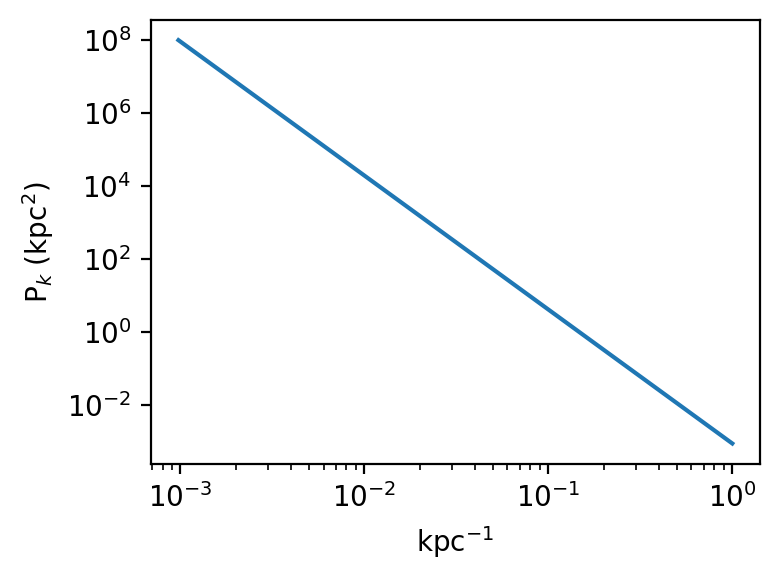

In [6]:
fig1,ax1 = SpectraPlottingSetup(ks,ps,units)

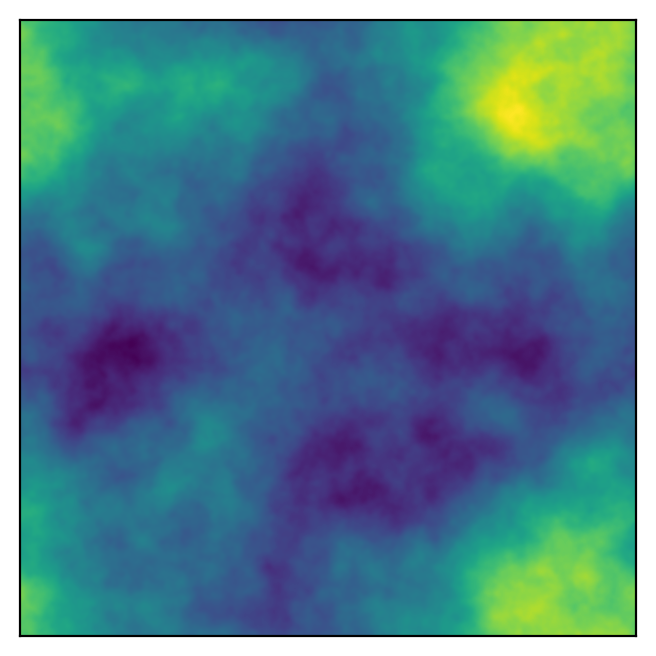

In [7]:
raw_image = PSobj.generate_realization()
image = imf.fourier_filtering_2d(raw_image,"gauss",pixfwhm)     # in Compton y
ShowImage(image)

In [8]:
intrinsic_mask = np.ones(image.shape) # Suppose there are bad pixels; those could be omitted with zeros in this array.
img2PS = CPS.PSfromImages(image,pixsize=pixsize,intrinsic_mask=intrinsic_mask)

In [9]:
img2PS.PSviaA12_2D_perK_perBin()

In [10]:
print(img2PS.A12_kn)
print(img2PS.A12_pk)

[0.00195312 0.00407013 0.00848178 0.01767524 0.03683355 0.0767577
 0.15995593 0.33333333]
[[1.40132032e+07]
 [8.32907499e+05]
 [5.50029812e+04]
 [3.69300066e+03]
 [2.33770358e+02]
 [1.12213429e+01]
 [3.11168734e-01]
 [5.18768989e-03]]


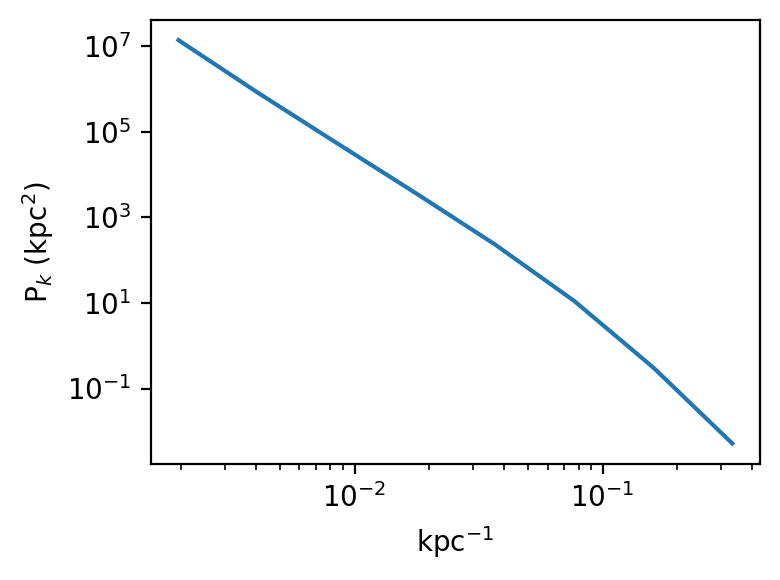

In [11]:
fig2,ax2 = SpectraPlottingSetup(img2PS.A12_kn,img2PS.A12_pk,units)

That's OK, but we're traversing quite a bit of power. Let's plot these as amplitude spectra

In 2D, $A_k = \sqrt{2 \pi k^2 P_k}$

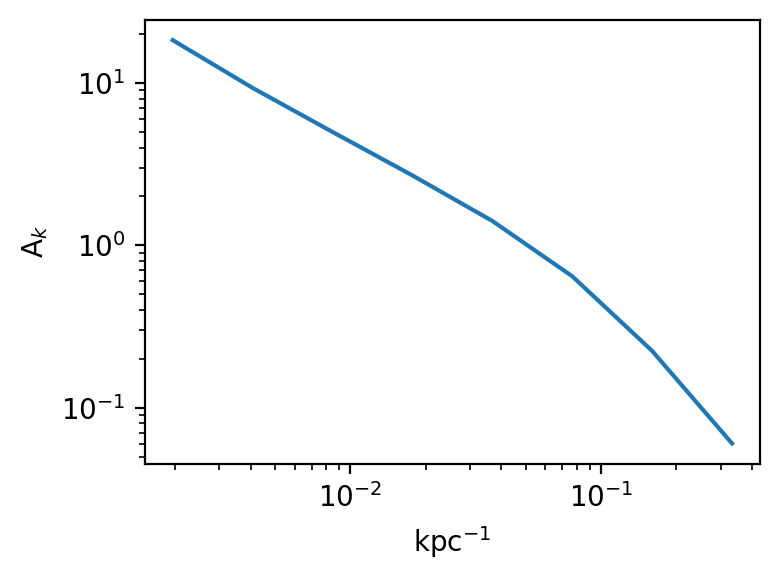

In [12]:
fig2,ax2 = SpectraPlottingSetup(img2PS.A12_kn,img2PS.A12_pk,units,AmpSpec=True)

In [14]:
img2PS.PSviaFFT_2D_noMask()

It looks like the curves inferred power spectra are quite noisy.

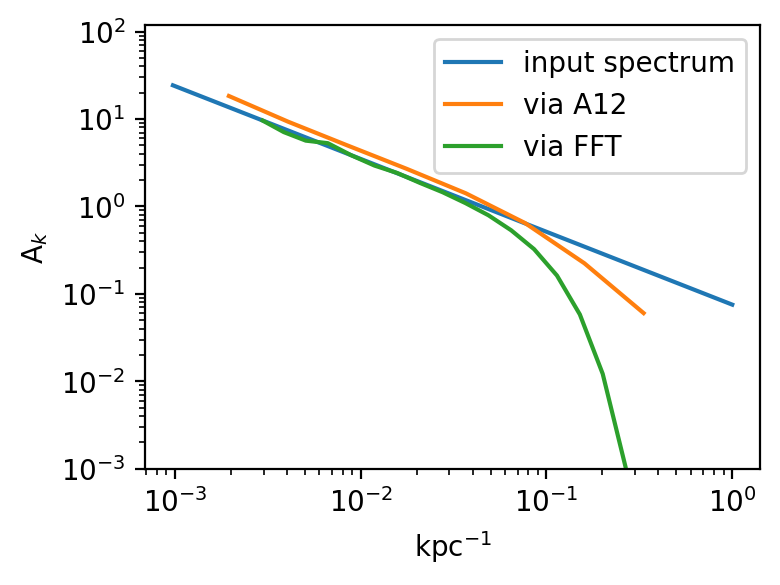

In [15]:
fig3,ax3 = SpectraPlottingSetup(ks,ps,units,AmpSpec=True,label="input spectrum")
SpectraPlottingSetup(img2PS.A12_kn,img2PS.A12_pk,units,AmpSpec=True,psax=ax3,label="via A12")
SpectraPlottingSetup(img2PS.FFT_kb,img2PS.FFT_pk,units,AmpSpec=True,psax=ax3,label="via FFT",
                     showLegend=True,ymin=1e-3)

Well even the FFT has some noise. This is due to sample (or cosmic) variance.

Given that we are generating images ("synthetic data") with a known power spectrum, we can simply increase this to generating N images, and take the averages of recovered spectra.

In [16]:
nImgs = 9
PS_viaA12 = np.zeros(img2PS.A12_pk.shape) #
PS_viaFFT = np.zeros(img2PS.FFT_pk.shape)  # 
for i in range(nImgs):
    print(i) 
    ##############################################################################
    raw_image = PSobj.generate_realization()
    image = imf.fourier_filtering_2d(raw_image,"gauss",pixfwhm)     # in Compton y
    ##############################################################################
    img2PS.update_img(image)
    img2PS.PSviaA12_2D_perK_perBin()
    img2PS.PSviaFFT_2D_noMask()
    PS_viaA12 += img2PS.A12_pk
    PS_viaFFT += img2PS.FFT_pk
PS_viaA12 /= nImgs
PS_viaFFT /= nImgs

0
1
2
3
4
5
6
7
8


In [21]:
sigma   = fwhm/(2.0*np.sqrt(2.0*np.log(2)))
ps_beam_A12 = np.exp(-4.0*img2PS.A12_kn*img2PS.A12_kn*sigma*sigma*np.pi*np.pi) # at appropriate k values
ps_beam_A12_reshape = ps_beam_A12.reshape(img2PS.A12_kn.shape+(1,))
ps_beam_A12_reshape = ps_beam_A12_reshape.repeat(PS_viaA12.shape[1],axis=1)
ps_beam_FFT = np.exp(-4.0*img2PS.FFT_kb*img2PS.FFT_kb*sigma*sigma*np.pi*np.pi) # at appropriate k values

(8, 1)
(8, 1)


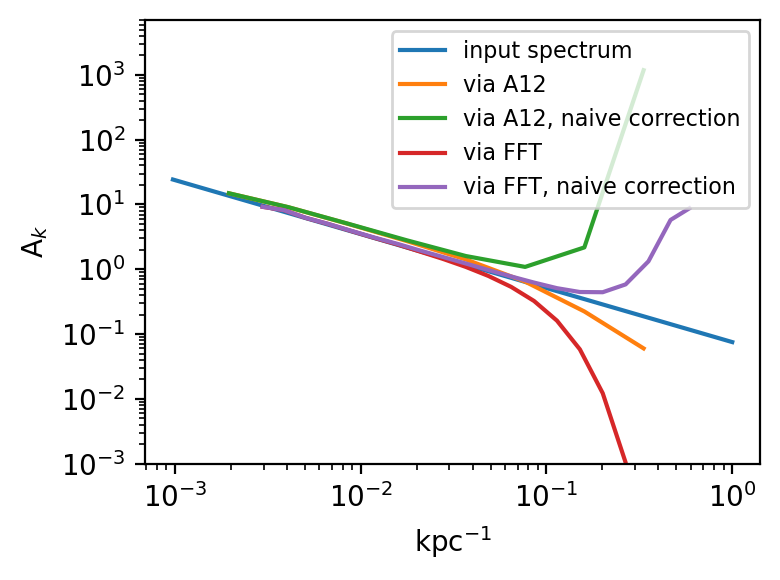

In [24]:
fig4,ax4 = SpectraPlottingSetup(ks,ps,units,AmpSpec=True,label="input spectrum")
SpectraPlottingSetup(img2PS.A12_kn,PS_viaA12,units,AmpSpec=True,psax=ax4,label="via A12")
SpectraPlottingSetup(img2PS.A12_kn,PS_viaA12/ps_beam_A12_reshape,units,AmpSpec=True,psax=ax4,
                     label="via A12, naive correction")
SpectraPlottingSetup(img2PS.FFT_kb,PS_viaFFT,units,AmpSpec=True,psax=ax4,label="via FFT",
                     ymin=1e-3)
SpectraPlottingSetup(img2PS.FFT_kb,PS_viaFFT/ps_beam_FFT,units,AmpSpec=True,psax=ax4,
                     label="via FFT, naive correction",showLegend=True,ymin=1e-3)

Since we're not concerned with the recovery at low-k, we don't have scatter due to sample (cosmic) variance.

However, neither of our corrections seem perfect.
The fact that the FFT correction isn't quite right has more to do with the `FFT, raw` measurement having some numerical effects of my doing. That is, I bin the data up, and the way I bin it doesn't do well when the (power-law) slope gets *really* steep.

The A12 correction also has a lot to do with the fact that the `A12, raw` measurement has its own bias (cf `FFT, raw` values at high k). To correct for a Gaussian PSF, an expression was derived in Romero+ 2023. This expression actually works for a PSF that can be described (characterized) by multiple Gaussians. The correction depends on both the power-law slope (assume the true power spectrum is just a power-law at the scale where the PSF has a significant impact) and the parameterization of the PSF.

In [32]:
# Let's do some more work with our beam. To do this, we'll use a class that allows for the beam to consist
# of multiple Gaussians. As such, the class will expect a beam to be characterize by iterable parameters.
normalizations = [1] # The iterable normalizations (height) of the Gaussian
sigmas = [sigma] # The iterable Gaussian sigmas (width)
PSF = CPS.MultiGaussBeam(normalizations,sigmas)
A12biasPSF = PSF.get_multiGauss_bias(img2PS.A12_kn,-PSobj.slope,ignPSF=True)
A12biasPSF_reshape = A12biasPSF.reshape(img2PS.A12_kn.shape+(1,)) # Could transpose and tile
A12biasPSF_reshape = A12biasPSF_reshape.repeat(PS_viaA12.shape[1],axis=1) # But this is sufficient

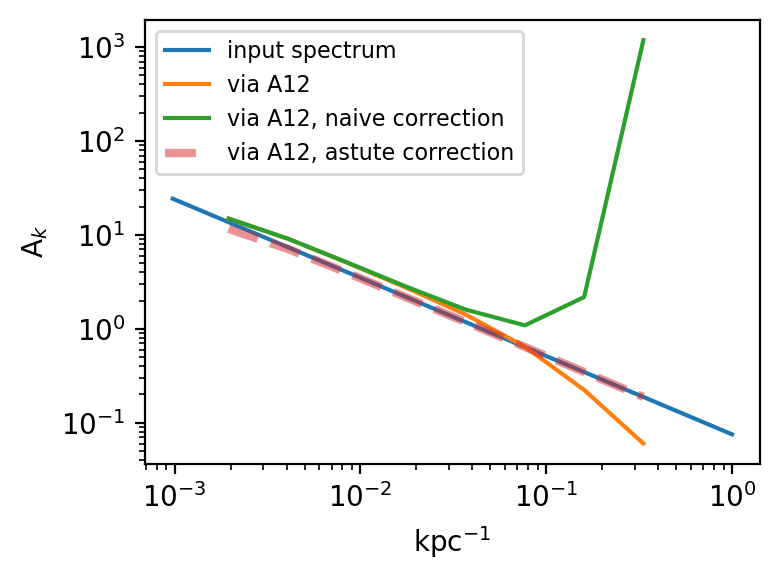

In [38]:
fig4,ax4 = SpectraPlottingSetup(ks,ps,units,AmpSpec=True,label="input spectrum")
SpectraPlottingSetup(img2PS.A12_kn,PS_viaA12,units,AmpSpec=True,psax=ax4,label="via A12")
SpectraPlottingSetup(img2PS.A12_kn,PS_viaA12/ps_beam_A12_reshape,units,AmpSpec=True,psax=ax4,
                     label="via A12, naive correction")
SpectraPlottingSetup(img2PS.A12_kn,PS_viaA12/A12biasPSF_reshape,units,AmpSpec=True,psax=ax4,
                     label="via A12, astute correction",ls="--",lw=3.0,showLegend=True,alpha=0.5)